## Problem definition

The main equation: $\nabla \cdot (-\sigma\nabla{V}) = 0$

Where both $\sigma(x)$ and $V(x)$ vary with position.

We assume Dirichlet boundary conditions: $V(0) = 0$ and $V(1) = 10$

Further, $\sigma$ is defined as:
$$
\sigma(x)=
\begin{cases}
1 & \quad \text{when $x<0.5$}\\
2 & \quad \text{otherwise}
\end{cases}
$$

To solve this analytically we need to devide the diffrential equation in two parts, one for $x<0.5$ and another for $x\geq0.5$. The double integration after using the boundary condition yields the result:
$$
V(x)=
\begin{cases}
\frac{40}{3}x & \quad \text{when $x<0.5$}\\
\frac{20}{3}x + \frac{10}{3} & \quad \text{otherwise}
\end{cases}
$$

## Solution using `skfem`

In [1]:
import skfem
import skfem.visuals.matplotlib
from skfem.helpers import grad, dot
import numpy as np

## Load mesh

In [2]:
mesh = skfem.mesh.Mesh.load("interval.msh")
mesh

Failure to parse tags from meshio.


<skfem MeshLine1 object>
  Number of elements: 100
  Number of vertices: 101
  Number of nodes: 101
  Named subdomains [# elements]: L1 [50], L2 [50]

In [3]:
mesh.subdomains

{'L1': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int32),
 'L2': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int32)}

### Define 1D mesh

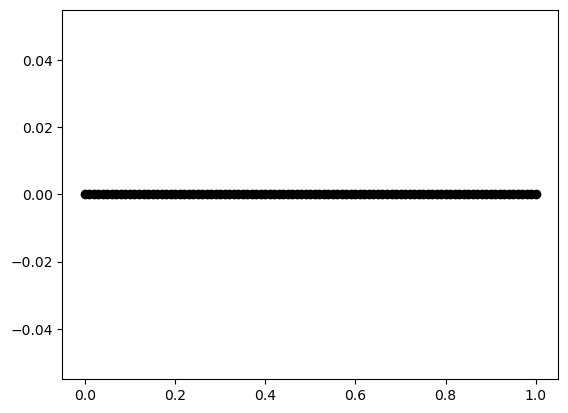

In [4]:
skfem.visuals.matplotlib.draw(mesh);

### Define function spaces

In [5]:
# For trial and test function
basis_p1 = skfem.Basis(mesh=mesh, elem=skfem.ElementLineP1())

# For material parameter sigma
basis_p0 = skfem.Basis(mesh=mesh, elem=skfem.ElementDG(skfem.ElementLineP0()))

In [6]:
basis_p0

<skfem CellBasis(MeshLine1, ElementDG) object>
  Number of elements: 100
  Number of DOFs: 100
  Size: 3200 B

In [7]:
basis_p1

<skfem CellBasis(MeshLine1, ElementLineP1) object>
  Number of elements: 100
  Number of DOFs: 101
  Size: 6400 B

### Define material parameter

In [8]:
sigma = basis_p0.zeros()
sigma[mesh.subdomains["L1"]] = 1
sigma[mesh.subdomains["L2"]] = 2

In [9]:
sigma

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [10]:
sigma_field = basis_p0.interpolate(sigma)

### Assemble the system matrices

In [11]:
@skfem.BilinearForm
def stifness_matrix(u, v, w):
    return - w.sigma * dot(grad(u), grad(v))

In [12]:
@skfem.LinearForm
def l(v, _):
    return 0 * v

In [13]:
S = stifness_matrix.assemble(basis_p1, sigma=sigma_field)

In [14]:
S

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 301 stored elements and shape (101, 101)>

In [15]:
L = l.assemble(basis_p1)

In [16]:
L

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Apply inhomogeneous Dirichlet BC

In [17]:
pot = basis_p1.zeros()
pot[basis_p1.get_dofs(lambda x: np.isclose(x[0], 0)).flatten()] = 0.
pot[basis_p1.get_dofs(lambda x: np.isclose(x[0], 1)).flatten()] = 10.

### Solve linear equations and plot

In [18]:
pot = skfem.solve(*skfem.condense(S, L, x=pot, D=basis_p1.get_dofs()))

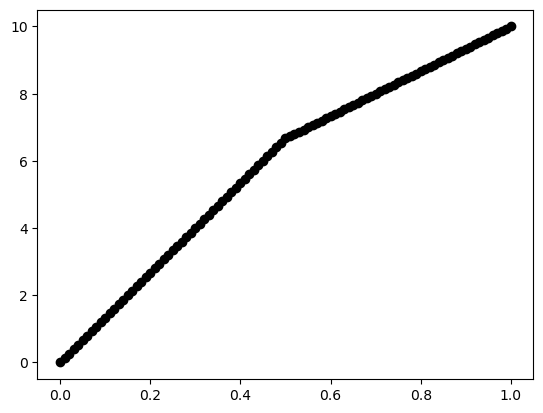

In [19]:
skfem.visuals.matplotlib.plot(mesh, pot);

## Comparing analytical and FEM solutions

In [20]:
analytical_pot = np.where(mesh.p[0]<0.5, mesh.p[0] * 40 / 3, (mesh.p[0] * 20 / 3) + (10/3))

In [21]:
np.linalg.norm(analytical_pot - pot)

np.float64(9.065226133860604e-13)

In [22]:
import matplotlib.pyplot as plt

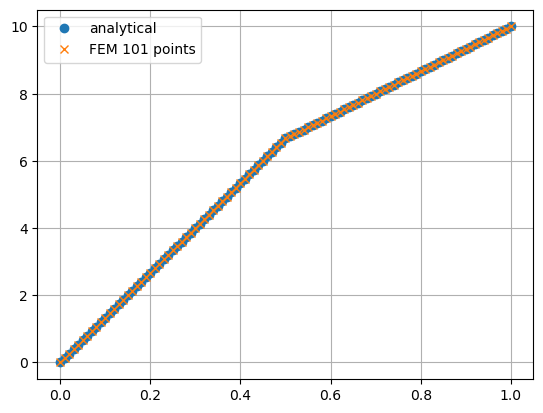

In [23]:
plt.plot(mesh.p[0], analytical_pot, "o", label="analytical")
plt.plot(mesh.p[0], pot, "x", label="FEM 101 points")
plt.legend()
plt.grid()
plt.show()

## Stiffness matrix

This is: $\mathbf{S}_{ij} = \int_{\Omega_{ij}} \sigma_{ij} \nabla\phi_i \cdot \nabla\phi_j \: \mathrm{d}x$

In [24]:
S.toarray()

array([[-100.,    0.,    0., ...,    0.,    0.,    0.],
       [   0., -300.,    0., ...,    0.,    0.,    0.],
       [   0.,    0., -200., ...,    0.,    0.,  200.],
       ...,
       [   0.,    0.,    0., ..., -400.,  200.,    0.],
       [   0.,    0.,    0., ...,  200., -400.,  200.],
       [   0.,    0.,  200., ...,    0.,  200., -400.]], shape=(101, 101))